In [1]:
import tidy3d as td
from tidy3d.plugins import waveguide
import tidy3d.web as web

import numpy as np
from matplotlib import pyplot as plt

from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver
from tidy3d.plugins.mode.web import run_batch

Function for creating the EME and FDTD simulation.

The `bends` argument is the list of tuples (length,bend_radius) containing the length and bend radius of each cell. 
The `wvgIn` and `wvgOut` arguments are the size of straight waveguides before and after the bent region.


In [2]:
def getBendEME(bends = [(1,1)],returnFDTD = True,
                wvgIn = 0,wvgOut = 0,
                plane_size = (10,10),
                num_modes = 5,
                target_neff = 1.545645,
                normalize_index = 0,
                normalize = True):    
                
    '''bends: list of tuple (lenght, bendRadius)'''
        

    width = 0.6
    thickness = 0.4

    # generic EMEModeSpec
    mode_spec = td.EMEModeSpec(
    num_modes=num_modes,
    bend_radius=None,
    bend_axis=1,
    num_pml=(12, 12),
    target_neff = target_neff ,
    ) 

    # just apply an offset in order to start the grid at 0. Just for visualization purposes
    size = 2 #offsets

    # add the straight sections if any
    if wvgIn > 0:
        bends = [(wvgIn,None)] + bends
    if wvgOut > 0:
        bends = bends + [(wvgOut,None)]
    

    mode_specs = []
    boundaries = []

    # iterate trough the cells to create each EMEModeSpec and boundaries
    for i,bend in enumerate(bends):
        
        
        length,radius = bend
        
        mode_specs.append(mode_spec.updated_copy(bend_radius=radius))


        if i == 0:
            boundaries = [length]
        elif i > 0:
            boundaries.append(boundaries[-1]+length)

        size += length


    eme_grid_spec = td.EMEExplicitGrid(boundaries=boundaries[:-1],
                                        mode_specs = mode_specs)

    # just adding monitors
    eme_field_mon = td.EMEFieldMonitor(
        name="field", 
        size=(td.inf, 0, td.inf)
    )

    eme_mode_mon = td.EMEModeSolverMonitor(
        name="modes", 
        size=(td.inf, td.inf, td.inf),
        center=(0, 0, 0),
    )

    eme_flux_mon = td.EMEFieldMonitor(name = 'flux',
                                    size = (0,3,3),
                                    center = (boundaries[-1],0,0))

    sio2 = td.material_library["SiO2"]["Palik_Lossless"]

    siN = td.Medium(permittivity = 2**2)

    structures = [td.Structure(attrs={}, 
                geometry=td.PolySlab(axis=2, sidewall_angle=0.0,
                slab_bounds=(-thickness/2, thickness/2),
                vertices=np.array([[-1e15, -width/2],
        [-1e15,  width/2],
        [1e15,  width/2],
        [ 1e15, -width/2]])), medium=siN)]

    sim = td.EMESimulation(
        size=(size, plane_size[0], plane_size[1]),
        medium=sio2,
        center = (size/2-1,0,0),
        structures=structures,
        axis=0,
        freqs=[td.C_0 / 1.55],
        eme_grid_spec=eme_grid_spec,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
        monitors = [eme_field_mon,eme_mode_mon,eme_flux_mon],
        port_offsets = (1,1),
        symmetry = (0,0,1),
        normalize = normalize

    )
  
    return sim

In [3]:
# 2um straight section at the end. 

wvgOut = 2
wvgIn = 0
length = [6*np.pi/2,6*np.pi,3*np.pi/2,3*np.pi/4]


emeData02 = []
for l in length:

    sim = getBendEME(wvgIn = wvgIn,wvgOut = wvgOut,bends= [(l,6)],plane_size = (10,10),
                                num_modes = 1,normalize = True)



    sim_data = web.run(sim, task_name="eme",verbose = False)
    emeData02.append(sim_data)

eme02_s12 = []
eme02_s21 = []
for sim_data in emeData02:
    eme_s21 = float(sim_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0,f=0).abs**2)
    eme_s12 = float(sim_data.smatrix.S12.isel(mode_index_in=0, mode_index_out=0,f=0).abs**2)

    eme02_s21.append(eme_s21)
    eme02_s12.append(eme_s12)

# FDTD data
fdtd02 = np.array([0.27058363444769606,
            0.07040436699748817,
            0.5282451321156039,
            0.7170267374320302])

Text(0, 0.5, 'transmittance')

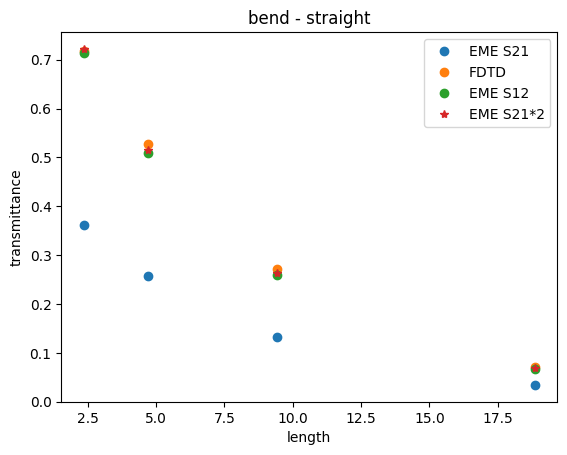

In [4]:
fig,ax = plt.subplots()
ax.plot(length,eme02_s21,'o',label = 'EME S21')
ax.plot(length,fdtd02,'o',label = 'FDTD')
ax.plot(length,eme02_s12,'o',label = 'EME S12')
ax.plot(length,[2*i for i in eme02_s21],'*',label = 'EME S21*2')
ax.legend()
ax.set_title('bend - straight')
ax.set_xlabel('length')
ax.set_ylabel('transmittance')

In [6]:
def FDTDError(data):
    return np.abs(np.array(data) - fdtd02).sum()
    
print(FDTDError (eme02_s21))
print(FDTDError (eme02_s12))

0.8017917658452234
0.03426437272763394
